In [51]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset,random_split,Dataset,ConcatDataset
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToPILImage
from torchsummary import summary
import matplotlib.pyplot as plt
import random
import cv2
import gc

In [52]:
class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 1 , kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        # Encoder
        x = self.encoder(x)
        
        # Decoder
        x = self.decoder(x)
        
        return x

In [53]:
class ColorizationModel_a(nn.Module):
    def __init__(self ):#,  encoder):
        super(ColorizationModel_a, self).__init__()
        # Use the provided encoder as the encoder of the new model
        # self.encoder = encoder
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 3 , kernel_size=3, stride=1, padding=1),  # Output has 3 channels
            nn.Tanh()
        )

    def forward(self, x):
        # Encoder
        # x = self.encoder(x)
        
        # Decoder
        x = self.decoder(x)
        
        return x

In [54]:
class ColorizationModel_b(nn.Module):
    def __init__(self):
        super(ColorizationModel_b, self).__init__()
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 3 , kernel_size=3, stride=1, padding=1),  # Output has 3 channels
            nn.Tanh()
        )

    def forward(self, x):
        # Decoder
        x = self.decoder(x)
        
        return x

In [55]:
class ColorCombinationModel(nn.Module):
    def __init__(self):
        super(ColorCombinationModel, self).__init__()
        # Define convolutional layers to process input channels
        self.conv1 = nn.Conv2d(in_channels=8, out_channels=30, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=30, out_channels=50, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=50, out_channels=1, kernel_size=3, padding=1)
        # Define activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Apply convolutional layers
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [56]:
def create_colorization_model_a():
    return ColorizationModel_a()
def create_colorization_model_b():
    return ColorizationModel_b()
def create_ColorCombinationModel():
    return ColorCombinationModel()

In [57]:
def load_models():
    # Fixed paths to model state dictionaries
    encoder_path = 'model_encoder_trained.pth'
    model_paths_a =['model_1.pth', 'model_2.pth', 'model_3.pth', 'model_4.pth']
    model_paths_b =['model_5.pth', 'model_6.pth', 'model_7.pth', 'model_8.pth'] 
    hue_path = 'model_Hue.pth'
    saturation_path = 'model_Saturation.pth'
    value_path = 'model_Value.pth'
    
    Auto_encoder = ColorizationModel()
    encoder = Auto_encoder.encoder
    encoder.load_state_dict(torch.load(encoder_path))

    # Load other models
    models = []
    for path in model_paths_a:
        model = create_colorization_model_a()
        model.load_state_dict(torch.load(path))
        models.append(model)
    for path in model_paths_b:
        model = create_colorization_model_b()
        model.load_state_dict(torch.load(path))
        models.append(model)
    # Load hue model
    hue_model = create_ColorCombinationModel()
    hue_model.load_state_dict(torch.load(hue_path))

    # Load saturation model
    saturation_model = create_ColorCombinationModel()
    saturation_model.load_state_dict(torch.load(saturation_path))

    # Load value model
    value_model = create_ColorCombinationModel()
    value_model.load_state_dict(torch.load(value_path))

    return encoder, models, hue_model, saturation_model, value_model

In [58]:
def combine_models(model_encoder, models, model_Hue, model_Saturation, model_Value, grayscale_image):
    # Pass the grayscale image through the encoder
    encoded_image = model_encoder(grayscale_image)
    
    # Initialize lists to store outputs from individual models
    hue_outputs = []
    saturation_outputs = []
    value_outputs = []
    
    # Iterate through each model and generate HSV outputs
    for model in models:
        hsv_output = model(encoded_image)
        
        # Split HSV output into individual channels
        hue_channel = hsv_output[:, 0:1, :, :]
        saturation_channel = hsv_output[:, 1:2, :, :]
        value_channel = hsv_output[:, 2:3, :, :]
        
        # Append each channel to respective lists
        hue_outputs.append(hue_channel)
        saturation_outputs.append(saturation_channel)
        value_outputs.append(value_channel)
    
    # Combine the outputs from all models
    combined_hue_output = torch.cat(hue_outputs, dim=1)
    combined_saturation_output = torch.cat(saturation_outputs, dim=1)
    combined_value_output = torch.cat(value_outputs, dim=1)
    
    # Combine the outputs to create HSV images
    colorized_image_hue = model_Hue(combined_hue_output)
    colorized_image_saturation = model_Saturation(combined_saturation_output)
    colorized_image_value = model_Value(combined_value_output)
    
    # Combine the colorized images into one
    colorized_image = torch.cat([colorized_image_hue, colorized_image_saturation, colorized_image_value], dim=1)
    
    return colorized_image

In [59]:
def visualize_color_enhancement(models, best_model_red, best_model_green, best_model_blue, grayscale_patches):
    red_channels   = []
    green_channels = []
    blue_channels  = []
    
    for patch in grayscale_patches:
        patch = patch.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
        for model in models:
            color_prediction = model(patch)
            red_channels.append(color_prediction[0, 0]) 
            green_channels.append(color_prediction[0, 1]) 
            blue_channels.append(color_prediction[0, 2]) 

    red_channels_tensor   = torch.stack(red_channels,   dim=0).unsqueeze(0)
    green_channels_tensor = torch.stack(green_channels, dim=0).unsqueeze(0)
    blue_channels_tensor  = torch.stack(blue_channels,  dim=0).unsqueeze(0)

    pred_red   = best_model_red(red_channels_tensor)
    pred_green = best_model_green(green_channels_tensor)
    pred_blue  = best_model_blue(blue_channels_tensor)

    stacked_channels = torch.cat([pred_red, pred_green, pred_blue], dim=1)

    # Create a placeholder for the final reconstructed image
    final_image = torch.zeros_like(stacked_channels)

    # Calculate the number of patches along each dimension
    num_patches = len(grayscale_patches)
    rows = int(np.sqrt(num_patches))
    cols = (num_patches + rows - 1) // rows

    plt.figure(figsize=(8, 4))

    for i, patch in enumerate(stacked_channels.split(1)):
        reshaped_patch = patch.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
        plt.subplot(rows, cols, i+1)
        plt.imshow(reshaped_patch)
        plt.title(f'Patch {i+1}')
        plt.axis('off')

        # Add the patch to the final image
        row_idx = i // cols
        col_idx = i % cols
        final_image[:, :, row_idx * 128:(row_idx + 1) * 128, col_idx * 128:(col_idx + 1) * 128] = patch

    plt.tight_layout()
    plt.show()

    return final_image


In [60]:
def convert_to_one_channel(image_path):
    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Unable to read image.")
        return None
    # Check number of channels
    num_channels = img.shape[2]
    if num_channels == 1:
        print("Image already has one channel.")
        return img
    elif num_channels == 3:
        # Convert to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)-0.5
        print("Converted image to one channel.")
        return gray_img
    else:
        print("Unsupported number of channels.")
        return None

In [61]:
def split_image_into_squares(image):
    squares = []
    locations = []

    height, width = image.shape[:2]
    square_size = 128

    for y in range(0, height, square_size):
        for x in range(0, width, square_size):
            square = image[y:y+square_size, x:x+square_size]
            # Adjust square size if it's smaller than expected
            square_height, square_width = square.shape
            if square_height < square_size or square_width < square_size:
                square = cv2.resize(square, (square_size, square_size))
            squares.append(square.reshape(1, square_size, square_size))  # Reshape the square
            locations.append((x, y))

    # Convert squares list to a tensor
    squares_tensor = torch.tensor(squares, dtype=torch.float)

    return squares_tensor, locations

In [62]:
encoder_model, models, hue_model, saturation_model, value_model = load_models()

In [63]:
image_path = "2.jpg"

result_image = convert_to_one_channel(image_path)


Converted image to one channel.


In [66]:
squares, locations = split_image_into_squares(result_image)
img_plot = combine_models(encoder_model, models, hue_model, saturation_model, value_model, squares)+0.5
max_x = max(location[0] for location in locations) + 128  # Get the maximum x coordinate
max_y = max(location[1] for location in locations) + 128  # Get the maximum y coordinate
output_tensor_resized = F.interpolate(img_plot, size=(max_y, max_x), mode='nearest')



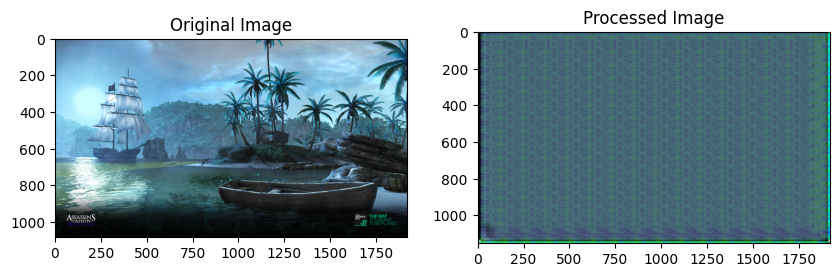

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with two subplots

img = cv2.imread(image_path)

axes[0].imshow(img)
axes[0].set_title('Original Image')

processed_image_tensor = output_tensor_resized[0]  # Assuming you want to display the first image in the batch

# Convert HSV image tensor to numpy array and scale values to [0, 255]
processed_image_np = processed_image_tensor.permute(1, 2, 0).detach().cpu().numpy() * 255
processed_image_np = processed_image_np.astype(np.uint8)

# Convert HSV to RGB
processed_image_rgb = cv2.cvtColor(processed_image_np, cv2.COLOR_HSV2RGB)
axes[1].imshow(processed_image_rgb)
axes[1].set_title('Processed Image')

plt.show()